In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import torch
import torchmetrics
import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

from pathlib import Path
from torch.utils.data import DataLoader

from torchfitter.trainer import Trainer
from torchfitter.utils import DataWrapper
from torchfitter.regularization import L1Regularization

from sklearn.model_selection import train_test_split

torch.manual_seed(0)
np.random.seed(0)

In [3]:
DATA_PATH = Path(os.path.abspath('')).parent / "tests/data"

In [4]:
X = np.load(DATA_PATH / "features.npy")
y = np.load(DATA_PATH / "labels.npy")

y = y.reshape(-1,1)

In [5]:
# simplest case of cross-validation
X_train, X_val, y_train, y_val = train_test_split(
    X, 
    y, 
    test_size=0.33, 
    random_state=42
)

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [7]:
model = nn.Linear(in_features=1, out_features=1)
model.to(device)

regularizer = L1Regularization(regularization_rate=0.01, biases=False)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.005)

In [8]:
from torchfitter.callbacks import LoggerCallback, EarlyStopping, LearningRateScheduler

In [9]:
callbacks = [
    LoggerCallback(update_step=100),
    EarlyStopping(patience=100, load_best=True),
    LearningRateScheduler(
        scheduler=optim.lr_scheduler.StepLR(optimizer, step_size=500, gamma=0.9)
    )
]

In [10]:
metrics = [
    torchmetrics.MeanSquaredError().to(device),
    torchmetrics.MeanAbsoluteError().to(device)
]

In [11]:
trainer = Trainer(
    model=model, 
    criterion=criterion,
    optimizer=optimizer, 
    regularizer=regularizer,
    device=device,
    callbacks=callbacks,
    metrics=metrics,
    mixed_precision=True
)

In [12]:
# wrap data in Dataset
train_wrapper = DataWrapper(
    X_train, 
    y_train, 
    dtype_X='float', 
    dtype_y='float'
)

val_wrapper = DataWrapper(
    X_val,
    y_val,
    dtype_X='float',
    dtype_y='float'
)

# torch Loaders
train_loader = DataLoader(train_wrapper, batch_size=64, pin_memory=True)
val_loader = DataLoader(val_wrapper, batch_size=64, pin_memory=True)

In [13]:
# fitting process
trainer.fit(train_loader, val_loader, epochs=500, disable_pbar=True)

INFO:root:Starting training process on cuda
INFO:root:Epoch 1/500 | Train loss: 8380.00049 | Validation loss 8668.01335 | Time/epoch: 0.26 s
INFO:root:Epoch 100/500 | Train loss: 7421.94762 | Validation loss 7691.73169 | Time/epoch: 0.03 s
INFO:root:Epoch 200/500 | Train loss: 6543.98677 | Validation loss 6796.39355 | Time/epoch: 0.03 s
INFO:root:Epoch 300/500 | Train loss: 5739.42671 | Validation loss 5972.72087 | Time/epoch: 0.04 s
INFO:root:Epoch 400/500 | Train loss: 4998.12837 | Validation loss 5211.75260 | Time/epoch: 0.03 s
INFO:root:Epoch 500/500 | Train loss: 4313.66739 | Validation loss 4507.70426 | Time/epoch: 0.04 s
INFO:root:End of training. Total time: 19.52414 seconds


In [14]:
# predictions
with torch.no_grad():
    y_pred = model(torch.from_numpy(X_val).float().to(device)).cpu().numpy()

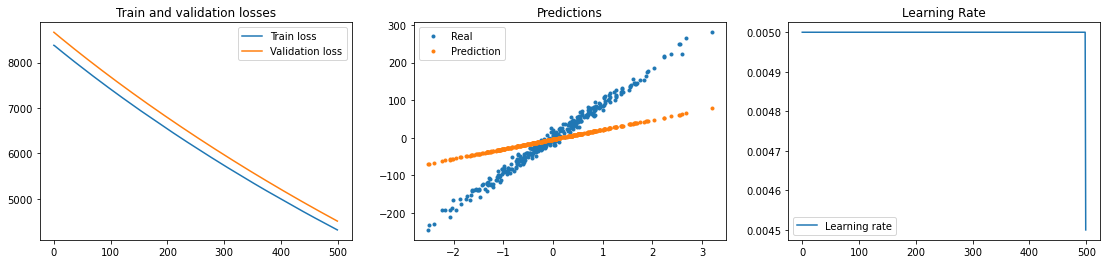

In [15]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(19,4))

ax[0].plot(trainer.internal_state.history['train_loss'], label='Train loss')
ax[0].plot(trainer.internal_state.history['validation_loss'], label='Validation loss')
ax[0].set_title('Train and validation losses')
ax[0].legend();

ax[1].plot(X_val, y_val, '.', label="Real")
ax[1].plot(X_val, y_pred, '.', label="Prediction")
ax[1].set_title('Predictions')
ax[1].legend();


ax[2].plot(trainer.internal_state.history['learning_rate'], label="Learning rate")
ax[2].set_title('Learning Rate')
ax[2].legend();

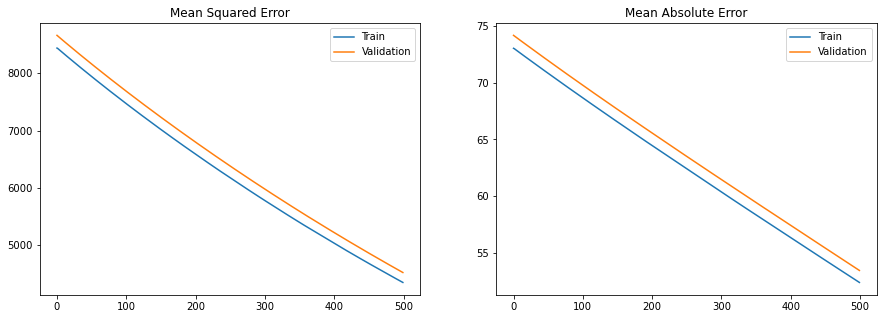

In [16]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

ax[0].plot(trainer.internal_state.history['MeanSquaredError']['train'], label='Train')
ax[0].plot(trainer.internal_state.history['MeanSquaredError']['validation'], label='Validation')
ax[0].set_title('Mean Squared Error')
ax[0].legend()


ax[1].plot(trainer.internal_state.history['MeanAbsoluteError']['train'], label='Train')
ax[1].plot(trainer.internal_state.history['MeanAbsoluteError']['validation'], label='Validation')
ax[1].set_title('Mean Absolute Error')
ax[1].legend()

In [17]:
from torchfitter.testing import compute_forward_gradient

In [18]:
class TestModule(torch.nn.Module):
    def __init__(self):
        super(TestModule, self).__init__()
        
    def forward(self, a, b):
        return (a - b).mean()

In [19]:
a = torch.rand(4, requires_grad=True)
b = torch.rand(4, requires_grad=True)

In [20]:
(a - b).mean()

tensor(0.0128, grad_fn=<MeanBackward0>)

In [21]:
test = TestModule()

In [22]:
res = test(a,b)

In [49]:
a = torch.ones(2, requires_grad=True)
b = torch.zeros(2, requires_grad=True)

In [50]:
obtained = compute_forward_gradient(test, a, b)

In [51]:
obtained

{0: tensor([0.5000, 0.5000]), 1: tensor([-0.5000, -0.5000])}

In [52]:
expected = {0: torch.Tensor([0.5, 0.5]), 1: torch.Tensor([-0.5, -0.5])}

In [53]:
expected

{0: tensor([0.5000, 0.5000]), 1: tensor([-0.5000, -0.5000])}

In [54]:
for k1, k2 in zip(obtained, expected):
    torch.testing.assert_allclose(obtained[k1], expected[k2])

---